# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import string
import re
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
from sklearn.metrics import ConfusionMatrixDisplay

# Import Data

In [2]:
df_cnn = pd.read_excel('/content/drive/MyDrive/data/Indonesian Fact and Hoax Political News/Cleaned/dataset_cnn_10k_cleaned.xlsx', index_col=0)
df_kompas = pd.read_excel('/content/drive/MyDrive/data/Indonesian Fact and Hoax Political News/Cleaned/dataset_kompas_4k_cleaned.xlsx', index_col=0)
df_tempo = pd.read_excel('/content/drive/MyDrive/data/Indonesian Fact and Hoax Political News/Cleaned/dataset_tempo_6k_cleaned.xlsx', index_col=0)
df_hoax = pd.read_excel('/content/drive/MyDrive/data/Indonesian Fact and Hoax Political News/Cleaned/dataset_turnbackhoax_10_cleaned.xlsx', index_col=0)

In [3]:
print("Shape of cnn data: {}".format(df_cnn.shape))
print("Shape of kompas data: {}".format(df_kompas.shape))
print("Shape of tempo data: {}".format(df_tempo.shape))
print("Shape of hoax data: {}".format(df_hoax.shape))

Shape of cnn data: (9630, 8)
Shape of kompas data: (4750, 8)
Shape of tempo data: (6592, 8)
Shape of hoax data: (10381, 10)


In [4]:
df_cnn.head(2)

,Title,Timestamp,FullText,Tags,Author,Url,text_new,hoax
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,"Selasa, 21 Feb 2023 21:22 WIB","Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",anies baswedan;pengajian;pilpres 2024;badan ko...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,"Selasa, 21 Feb 2023 20:46 WIB","Medan, CNN Indonesia -- Gubernur Sumatera Utar...",edy rahmayadi;pemilu 2024;pilkada 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0


In [5]:
df_hoax = df_hoax[df_hoax['politik'] == 1]

In [6]:
df_cnn = df_cnn[['text_new','hoax']]
df_kompas = df_kompas[['text_new','hoax']]
df_tempo = df_tempo[['text_new','hoax']]
df_hoax = df_hoax[['Clean Narasi','hoax']]

df_cnn = df_cnn.rename(columns = {'text_new':'text'})
df_kompas = df_kompas.rename(columns = {'text_new':'text'})
df_tempo = df_tempo.rename(columns = {'text_new':'text'})
df_hoax = df_hoax.rename(columns = {'Clean Narasi':'text'})

df = pd.concat([df_cnn, df_kompas, df_tempo, df_hoax])
df

,text,hoax
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
10377,PAS KAMPANYE ada warning dugaan PKI bangkit di...,1
10378,"Pada 16 April lalu, Menteri Perdagangan Rachma...",1
10380,"hehe, selalu bisa tersenyum melihat tingkah la...",1
10381,Pak Jokowi itu menjadi walikota periode pertam...,1


# Data Preprocessing

## Data Cleaning

In [7]:
df.iloc[4,0]

'PKN Siapkan Jabatan Khusus Buat Anas Urbaningrum Usai Bebas April  Dewan Pimpinan Pusat (DPP) Partai Kebangkitan Nusantara (PKN) menyiapkan jabatan khusus untuk Anas Urbaningrum\xa0usai bebas dari penjara pada pada April mendatang. Ketua Umum PKN I Gede Pasek Suardika mengatakan Anas akan menduduki jabatan khusus bersama Laksamana Sukardi yang baru saja menjadi kader. "Kita berharap Mas Anas dan Pak Laks [Laksamana Sukardi] nanti di dalam satu jabatan khusus," kata Pasek di kantor pusat PKN, Menteng, Jakarta Pusat, Selasa (21/1).                   Pasek belum menyebutkan secara gamblang apa jabatan khusus tang dimaksud. Dia hanya mengatakan posisi itu penentu arah perjuangan partai. Menurut Pasek, Anas dan Sukardi memiliki kesamaan sebagai tokoh yang sama-sama pernah dikriminalisasi. Namun, Anas dinilai hanya kurang beruntung karena langsung berhadapan dengan penguasa\xa0kala itu. "Bedanya beliau [Sukardi] mampu tegar teguh melawan, sehingga selamat. Sementara Mas Anas karena mungkin 

In [8]:
df.isna().sum()

text    881
hoax      0
dtype: int64

In [9]:
# Drop missing value
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## Text preprocessing

In [10]:
df_kompas.iloc[110,0]

'Pemerintah Diminta Tambah Subsidi Parpol dan Kampanye Cegah Kepala Daerah Korupsi Rule of Law Index, serta Varieties of Democracy Project. Menurut Wawan, penurunan skor sejumlah indikator itu, dalam jumlah 1 hingga 2 poin, tidak akan menunjukkan perubahan situasi yang signifikan. Sebaliknya, jika skor IPK turun 4 atau naik lebih dari 3, maka akan berdampak signifikan, baik positif maupun negatif. Berdasarkan 9 indikator tersebut, Indonesia mengalami penurunan skor pada 3 indikator, kemudian 3 indikator stagnan, dan 2 indikator mengalami kenaikan. Wawan menuturkan, dari sembilan skor tersebut, Political Risk Service (PRS) melorot hingga 13 poin, yang pada 2021 sebanyak 48 poin menjadi 35 pada tahun ini. “Itu turut menyumbang penurunan CPI kita dari 38 ke 34 tahun ini,” ujar Wawan. Menanggapi hal itu, Presiden Joko Widodo menyatakan akan menjadi bahan koreksi dan evaluasi pemerintah. "Iya itu akan menjadi koreksi dan evaluasi kita bersama," kata Jokowi dalam keterangan pers seusai menin

In [11]:
# removing breaking space
def remove_breaking_space(text):
  return text.replace('\xa0', ' ')

# removing spaces that appear more than once
def remove_unused_space(text):
  return re.sub(' +', ' ', text)

# remove text inside parentheses
def remove_parentheses(text):
  return re.sub("[\(\[].*?[\)\]]", "", text)

# turn text to lowercases
def lowercasing(text):
  return text.lower()

# give space for punctuation
def punctuation_spacing(text):
  for punct in string.punctuation:
    text = text.replace(punct, f' {punct} ')

  return re.sub(' +', ' ', text)

df['text'] = df['text'].map(lambda x: remove_breaking_space(x))
df['text'] = df['text'].map(lambda x: remove_unused_space(x))
df['text'] = df['text'].map(lambda x: remove_parentheses(x))
df['text'] = df['text'].map(lambda x: lowercasing(x))
df['text'] = df['text'].map(lambda x: punctuation_spacing(x))

In [12]:
df = df.rename(columns = {'hoax':'labels'})

In [13]:
df_cnn.iloc[0,0]

'Anies di Milad BKMT: Pengajian Menghasilkan Ibu-ibu Berpengetahuan  Mantan Gubernur DKI Jakarta Anies Baswedan menghadiri acara tasyakuran Milad ke-42 tahun Badan Kontak Majelis Taklim (BKMT) di Istora Senayan, Jakarta, Selasa (21/2). Dia pun memuji eksistensi ibu-ibu pengajian mewujudkan keberhasilan pendidikan di dalam keluarga. Ia mengatakan selama 42 tahun usianya, BKMT telah menjadi teladan keberhasilan pendidikan dalam keluarga.\xa0BKMT, kata dia, menjadi bukti bahwa pengajian menghasilkan ibu-ibu yang lebih berpengetahuan.       "BKMT menjadi bukti bahwa pengajian menghasilkan ibu-ibu yang lebih berpengetahuan. Ibu-ibu yang punya bekal untuk mendidik anak-anaknya, membuat rumah yang mencerminkan nilai Islam dan akhlak yang baik," kata Anies\xa0dikutip dari unggahan\xa0akun\xa0media sosial Instagram miliknya.             Dalam unggahannya, Anies menyinggung soal BKMT yang tidak dapat dilepaskan dari sosok Tuty Alawiyah. Menurut Anies, Tuty bukan hanya seorang ustazah yang mampu 

In [14]:
df.iloc[0,0]

'anies di milad bkmt : pengajian menghasilkan ibu - ibu berpengetahuan mantan gubernur dki jakarta anies baswedan menghadiri acara tasyakuran milad ke - 42 tahun badan kontak majelis taklim di istora senayan , jakarta , selasa . dia pun memuji eksistensi ibu - ibu pengajian mewujudkan keberhasilan pendidikan di dalam keluarga . ia mengatakan selama 42 tahun usianya , bkmt telah menjadi teladan keberhasilan pendidikan dalam keluarga . bkmt , kata dia , menjadi bukti bahwa pengajian menghasilkan ibu - ibu yang lebih berpengetahuan . " bkmt menjadi bukti bahwa pengajian menghasilkan ibu - ibu yang lebih berpengetahuan . ibu - ibu yang punya bekal untuk mendidik anak - anaknya , membuat rumah yang mencerminkan nilai islam dan akhlak yang baik , " kata anies dikutip dari unggahan akun media sosial instagram miliknya . dalam unggahannya , anies menyinggung soal bkmt yang tidak dapat dilepaskan dari sosok tuty alawiyah . menurut anies , tuty bukan hanya seorang ustazah yang mampu memimpin rat

In [15]:
df

,text,labels
0,anies di milad bkmt : pengajian menghasilkan i...,0
1,edy soal pilgub sumut : kalau yang maju abal -...,0
2,pkb bakal daftarkan menaker ida fauziyah jadi ...,0
3,gede pasek doakan ahy jadi capres atau cawapre...,0
4,pkn siapkan jabatan khusus buat anas urbaningr...,0
...,...,...
22337,pas kampanye ada warning dugaan pki bangkit di...,1
22338,"pada 16 april lalu , menteri perdagangan rachm...",1
22339,"hehe , selalu bisa tersenyum melihat tingkah l...",1
22340,pak jokowi itu menjadi walikota periode pertam...,1


In [16]:
# under sampling
from imblearn.under_sampling import RandomUnderSampler

X = df[['text']]
y = df['labels']
rus = RandomUnderSampler(random_state=1, replacement=False)
X_new, y_new = rus.fit_resample(X,y)

df = X_new
df['labels'] = y_new

In [17]:
ds = Dataset.from_pandas(df).train_test_split(seed=1, test_size=0.2)
ds_test_eval = ds['test'].train_test_split(seed=1, test_size=0.5)

In [18]:
ds_train = ds['train']
ds_eval = ds_test_eval['train']
ds_test = ds_test_eval['test']

In [19]:
ds_train

Dataset({
    features: ['text', 'labels'],
    num_rows: 2235
})

In [20]:
ds_test

Dataset({
    features: ['text', 'labels'],
    num_rows: 280
})

# Tokenizing

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def tokenize_dataset(data):
  # Keys of the returned dictionary will be added to the dataset as columns
  return tokenizer(data['text'], padding=True, truncation=True, max_length=512)

ds_train_ = ds_train.map(tokenize_dataset)
ds_eval_ = ds_eval.map(tokenize_dataset)
ds_test_ = ds_test.map(tokenize_dataset)

Map:   0%|          | 0/2235 [00:00<?, ? examples/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

In [24]:
ds_train_tokenized = ds_train_.remove_columns(['text'])
ds_eval_tokenized = ds_eval_.remove_columns(['text'])
ds_test_tokenized = ds_test_.remove_columns(['text'])

ds_token = DatasetDict({
    'train': ds_train_tokenized,
    'eval':ds_eval_tokenized,
    'test': ds_test_tokenized
    }
)

ds_token

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2235
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 279
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 280
    })
})

# Model Training

In [25]:
batch_size = 16
args = TrainingArguments(
    output_dir=f"IndoBERT-HoaxDetection",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
)

In [26]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-26-00a058ec9726>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [27]:
model = model.to(device)

trainer = Trainer(
    model,
    args,
    train_dataset=ds_token["train"],
    eval_dataset=ds_token["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [28]:
os.environ["WANDB_DISABLED"] = "true"
trainer.evaluate(eval_dataset=ds_token["test"])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.3705313205718994,
 'eval_accuracy': 0.45357142857142857,
 'eval_runtime': 9.7055,
 'eval_samples_per_second': 28.85,
 'eval_steps_per_second': 1.855}

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.062664,0.982079
2,No log,0.120232,0.974910
3,No log,0.102784,0.985663
4,0.065600,0.099222,0.985663
5,0.065600,0.104505,0.985663


TrainOutput(global_step=700, training_loss=0.04701042505247252, metrics={'train_runtime': 1144.4039, 'train_samples_per_second': 9.765, 'train_steps_per_second': 0.612, 'total_flos': 2890274167865874.0, 'train_loss': 0.04701042505247252, 'epoch': 5.0})

In [30]:
trainer.evaluate(eval_dataset=ds_token["test"])

{'eval_loss': 0.06410187482833862,
 'eval_accuracy': 0.9821428571428571,
 'eval_runtime': 9.5266,
 'eval_samples_per_second': 29.391,
 'eval_steps_per_second': 1.889,
 'epoch': 5.0}

In [32]:
trainer.save_model()

# Evaluation

In [33]:
pred_output = trainer.predict(test_dataset=ds_token['test'])

In [36]:
pred_label = np.argmax(pred_output.predictions, axis=1)

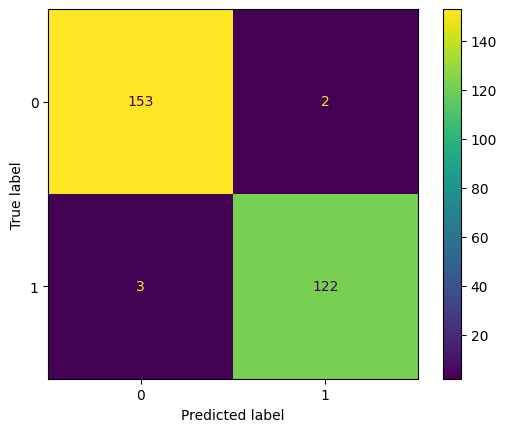

In [37]:
ConfusionMatrixDisplay.from_predictions(pred_label, ds_token['test']['labels'])